In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
from scipy.interpolate import RegularGridInterpolator

from eels_utils.ElectronSpectrum import ElectronSpectrum as es

In [2]:
# Tstep_factor = (1e-6 / 3e8)
# t0_sec = 0.2e-12
# t0 = t0_sec / Tstep_factor
# t0
# 0.2 * 3 * 10 ** (8 + 6 -12)
# 0.5 * 0.1e-6 / (3 * 10**(8))

In [3]:
resolution = 5
# InAs model


alpha = 7
# depth = 7


csecmusmec = 3 * 10**14
Time_Sec_To_MEEP = (1e-6 / 3e8)
Time_MEEP_To_Sec = 1 / Time_Sec_To_MEEP

# Tstep_ps = (1e-6 / 3e8 * 1e12)
# Tstep_factor = (1e-6 / 3e8) * S

def current_pd(depth, weight):
    n_eq = 1e23
    n_exc = 3.14e23 * np.exp(-abs(depth) * alpha) 
    gamma_sec = 3.3e12 

    omega_eq = 20.7539 * np.sqrt(n_eq)
    omega_exc = 44.5865 * np.sqrt(n_exc)
    omega_z_sec = np.sqrt(omega_exc**2 + omega_eq**2 - gamma_sec**2 / 4)
    
    
    omega_z = omega_z_sec / csecmusmec
    gamma = gamma_sec / csecmusmec

    t0_sec = 0.2e-12
    t0 = t0_sec / Time_Sec_To_MEEP

    return lambda t: weight * n_exc * np.sin(  omega_z *  (t-t0)) * np.exp(-gamma * (t-t0)/2) / omega_z if t>t0 else 0

def current_rectification(sigma, weight, t0):
    return lambda t: - weight * (t-t0) * np.exp(- ((t-t0) ** 2) / (2 * sigma **2))
    

In [4]:

distance_from_surface = 1
# depth = alpha
t0_sec = 0.2e-12
sigma_t_sec = 50e-15 / (2 * np.sqrt(2*np.log(2)))

sigma_t = sigma_t_sec / Time_Sec_To_MEEP
t0 = t0_sec  / Time_Sec_To_MEEP

# Phi = np.pi * (60) / 180

sx = 200
sy = 50
dpml = 10

cell = mp.Vector3(sx + 2 * dpml, sy + 2 * dpml)
pml_layers = [mp.PML(dpml)]

penetration_d = 1/alpha

def polarized_source(phi):
    return  [
        #         mp.Source(
        # src=mp.CustomSource(src_func=current_rectification(sigma_t, -np.sqrt(1/3),t0)),
        # center=mp.Vector3(0,-0.5 * (1/alpha)),
        # component=mp.Ey),
        #     mp.Source(
        # src=mp.CustomSource(src_func=curent_rectification(sigma_t,  - 2 * np.sin(2 * phi) * np.sqrt(1/6),t0)),
        # center=mp.Vector3(0,-0.5 * alpha),
        # component=mp.Ez),
            mp.Source(
        src=mp.CustomSource(src_func=current_rectification(sigma_t,   2 * np.cos(2 * phi) * np.sqrt(1/6),t0)),
        center=mp.Vector3(0,-0.5 * (1/alpha)),
        component=mp.Ex)
            ]

def pd_source(weight):
    return  [
        #         mp.Source(
        # src=mp.CustomSource(src_func=curent_rectification(sigma_t, -np.sqrt(1/3),t0)),
        # center=mp.Vector3(0,-0.5 * alpha),
        # component=mp.Ey),
        #     mp.Source(
        # src=mp.CustomSource(src_func=curent_rectification(sigma_t,  - 2 * np.sin(2 * phi) * np.sqrt(1/6),t0)),
        # center=mp.Vector3(0,-0.5 * alpha),
        # component=mp.Ez),
            mp.Source(
        src=mp.CustomSource(src_func= current_pd(depth = 0.5 * (1/alpha), weight = weight) ),
        center=mp.Vector3(0,-0.5 * (1/alpha)),
        component=mp.Ey)
            ]

fp_sec = omega_eq = 20.7539 * np.sqrt(1e23) / (2  * np.pi) * np.sqrt(0.05)
fp = fp_sec/csecmusmec
gamma_c = 3.3e12 / (2  * np.pi) / csecmusmec 

omega_TO_cm = 218
omega_LO_cm = 240
gamma_PH_cm = 3.5

freq_TO = omega_TO_cm * 3e10 / csecmusmec
freq_LO = omega_LO_cm * 3e10 / csecmusmec
gamma_ph = gamma_PH_cm * 3e10 / csecmusmec * 5

drude = mp.DrudeSusceptibility(frequency=fp, sigma=12, gamma=gamma_c)
lor = mp.LorentzianSusceptibility(frequency= freq_TO, gamma=gamma_ph, sigma=11)

geometry = [
    mp.Block(
        mp.Vector3(mp.inf, sy/2 + dpml, mp.inf),
        center=mp.Vector3(0,-sy/4 - dpml/2),
        material=mp.Medium(epsilon=12, E_susceptibilities=[lor]),
    )
]

def create_simulation_meep(phi):

    return mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=polarized_source(phi),
        resolution=resolution,
        symmetries=None,
        progress_interval = 15
    )

def create_simulation_pd(weight):

    return mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=pd_source(weight),
        resolution=resolution,
        symmetries=None,
        progress_interval = 15
    )







# %matplotlib inline
# plt.figure(dpi=100)
# sim.plot2D()
# plt.show()

In [5]:
 # \mu m
Nsteps = 500

def field_calculate_pd(weight, record_interval):
        sim = create_simulation_pd(weight)
        
        vals = []

        def get_slice(sim):
                vals.append(sim.get_array(center=mp.Vector3(0,distance_from_surface),
                              size=mp.Vector3(sx,0), 
                              component=mp.Ex))

            # %matplotlib inline
        plt.figure(dpi=100)
        sim.plot2D()
        plt.show()
    
        sim.reset_meep()
        sim.run(mp.at_every(record_interval, get_slice),
                until=Nsteps)
        return sim, vals

def field_calculate(phi, record_interval):
        sim = create_simulation_meep(phi)

        plt.figure(dpi=100)
        sim.plot2D()
        plt.show()
    
        vals = []

        def get_slice(sim):
                vals.append(sim.get_array(center=mp.Vector3(0,distance_from_surface),
                              size=mp.Vector3(sx,0), 
                              component=mp.Ex))

        sim.reset_meep()
        sim.run(mp.at_every(record_interval, get_slice),
                until=Nsteps)
        return sim, vals

     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


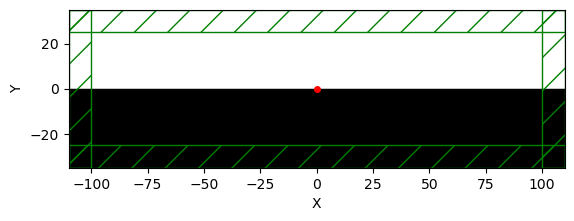

-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 2D dimensions.
Computational cell is 220 x 70 x 0 with resolution 5
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.385413 s
lorentzian susceptibility: frequency=0.0218, gamma=0.00175
-----------
on time step 762 (time=76.2), 0.00525522 s/step
on time step 1543 (time=154.3), 0.00512244 s/step
on time step 2312 (time=231.2), 0.00520488 s/step
Meep progress: 288.2/500.0 = 57.6% done in 15.0s, 11.0s to go
on time step 3072 (time=307.2), 0.00526424 s/step
on time step 3874 (time=387.4), 0.00499319 s/step
on time step 4661 (time=466.1), 0.00508347 s/step
run 0 finished at t = 500.0 (5000 timesteps)
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12

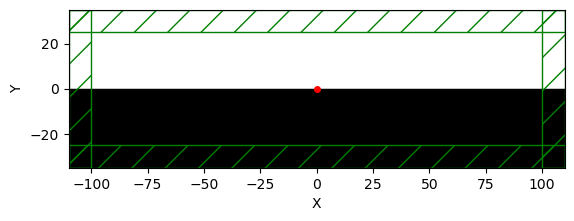

-----------
Initializing structure...
time for choose_chunkdivision = 0.000299215 s
Working in 2D dimensions.
Computational cell is 220 x 70 x 0 with resolution 5
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.386817 s
lorentzian susceptibility: frequency=0.0218, gamma=0.00175
-----------
on time step 751 (time=75.1), 0.00532765 s/step
on time step 1539 (time=153.9), 0.00507907 s/step
on time step 2317 (time=231.7), 0.00514391 s/step
Meep progress: 290.1/500.0 = 58.0% done in 15.0s, 10.9s to go
on time step 3103 (time=310.3), 0.00509042 s/step
on time step 3901 (time=390.1), 0.00501642 s/step
on time step 4647 (time=464.7), 0.00536451 s/step
run 0 finished at t = 500.0 (5000 timesteps)
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12

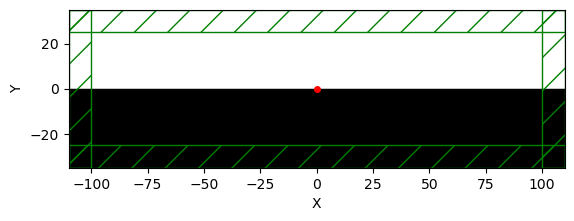

-----------
Initializing structure...
time for choose_chunkdivision = 0.000300884 s
Working in 2D dimensions.
Computational cell is 220 x 70 x 0 with resolution 5
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.40531 s
lorentzian susceptibility: frequency=0.0218, gamma=0.00175
-----------
on time step 801 (time=80.1), 0.00499822 s/step
on time step 1587 (time=158.7), 0.00509521 s/step
on time step 2373 (time=237.3), 0.0050916 s/step
Meep progress: 297.0/500.0 = 59.4% done in 15.0s, 10.3s to go
on time step 3167 (time=316.7), 0.00504043 s/step
on time step 3960 (time=396), 0.00504728 s/step
on time step 4716 (time=471.6), 0.00529669 s/step
run 0 finished at t = 500.0 (5000 timesteps)


In [6]:
field_list = []

# for angle in [0]:
#     sim, vals = field_calculate(np.pi * angle / 180)
#     field_list.append(vals)

record_interval = 2
sim, vals_or_0 = field_calculate(np.pi * 0 / 180, record_interval)
sim, vals_or_90 = field_calculate(np.pi * 90 / 180, record_interval)
sim_pd, vals_pd = field_calculate_pd(1e-6, record_interval)


In [38]:
(x,y,z,w)=sim_pd.get_array_metadata(center=mp.Vector3(0,1), size=mp.Vector3(sx,0))
xc = np.array(x)
spot_size_fwhm_or = 60
spot_size_fwhm_pd = 30

field_pd = es.convolve_laser_profile(np.array(vals_pd), xc, spot_size_fwhm_pd)
field_or_0 = es.convolve_laser_profile(np.array(vals_or_0), xc, spot_size_fwhm_or)
field_or_90 = es.convolve_laser_profile(np.array(vals_or_90), xc, spot_size_fwhm_or)

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

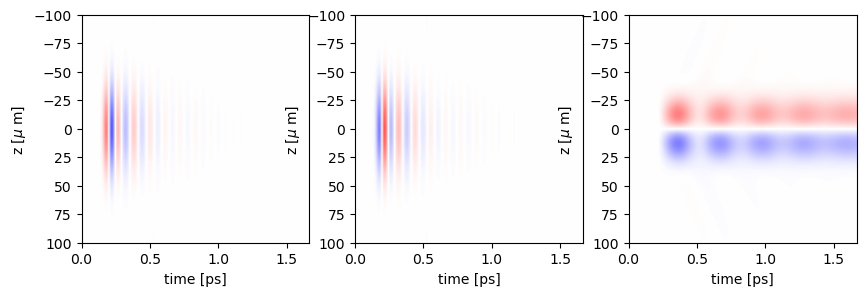

In [39]:
time_range = Nsteps / Time_MEEP_To_Sec * 1e12

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow(field_or_90.T , cmap='bwr',
            aspect = time_range / sx,
            extent = [0,time_range,-sx/2,sx/2])
plt.clim(vmin=-2 * np.max(field_or_90.T), vmax=2 * np.max(field_or_90.T))
plt.xlim([0,time_range])
plt.ylim([-sx/2,sx/2])
plt.gca().invert_yaxis()
plt.xlabel('time [ps]')
plt.ylabel('z [$\mu$ m]')
plt.colorbar

plt.subplot(1,3,2)
plt.imshow(field_or_0.T , cmap='bwr',
            aspect = time_range / sx,
            extent = [0,time_range,-sx/2,sx/2])
plt.clim(vmin=-2 * np.max(field_or_90.T), vmax=2 * np.max(field_or_90.T))
plt.xlim([0,time_range])
plt.ylim([-sx/2,sx/2])
plt.gca().invert_yaxis()
plt.xlabel('time [ps]')
plt.ylabel('z [$\mu$ m]')
plt.colorbar

plt.subplot(1,3,3)
plt.imshow(field_pd.T , cmap='bwr',
            aspect = time_range / sx,
            extent = [0,time_range,-sx/2,sx/2])
plt.clim(vmin=-2 * np.max(field_pd.T), vmax=2 * np.max(field_pd.T))
plt.xlim([0,time_range])
plt.ylim([-sx/2,sx/2])
plt.gca().invert_yaxis()
plt.xlabel('time [ps]')
plt.ylabel('z [$\mu$ m]')
plt.colorbar


In [40]:
# start_time = record_interval * Time_Sec_To_MEEP * 1e12
# end_time = time_range
# step = start_time

t_vec = np.arange(0, time_range, record_interval / Time_MEEP_To_Sec * 1e12)
z_vec = np.array(x)
delta_t = np.linspace(-1,1.5,201)

eels_pd = es.field_to_eels(field_pd, t_vec, z_vec, delta_t)
eels_or_0 = es.field_to_eels(field_or_0, t_vec, z_vec, delta_t)
eels_or_90 = es.field_to_eels(field_or_90, t_vec, z_vec, delta_t)

In [41]:
import scipy.io

# Save the array to a .mat file
scipy.io.savemat('my_data_2.mat', {'e_or_0': vals_or_90, 'zstep': z_vec[2]-z_vec[1], 'tstep' : record_interval / Time_MEEP_To_Sec * 1e12})

(250, 1002)

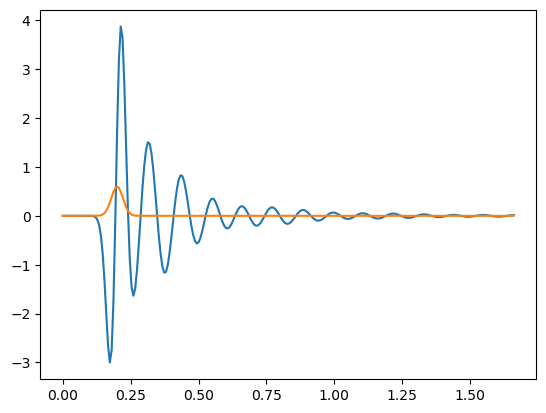

In [42]:
# Time_Step_ps
# (field_or_0.shape)
# (Time_Step_ps * 250)
sigma_t_ps = sigma_t_sec * 1e12 
laser_i = 0.6 * np.exp(- ((t_vec-0.2) **2) / (2 * sigma_t_ps **2))

plt.plot(t_vec, field_or_0[:,field_or_0.shape[1]//2])
plt.plot(t_vec, laser_i)

field_or_0.shape

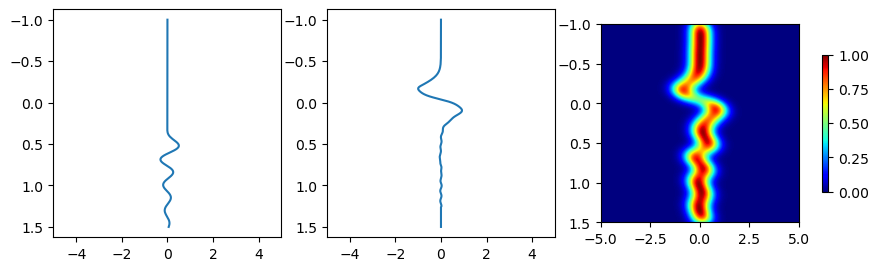

In [43]:
normalize_eels = lambda eels, weight: eels / max(np.abs(eels)) * weight 

def shift_elements(arr, num, fill_value):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

DeltaEmax = 5

norm_shifted_eels_pd = shift_elements(normalize_eels(eels_pd, .5),20,0)
norm_shifted_eels_or = shift_elements(normalize_eels(eels_or_0, 1),-20,0)

psi_coherent = es.eels_to_psi_coherent(norm_shifted_eels_pd + norm_shifted_eels_or,  delta_t)
psi_incoherent_non_normalised = es.psi_coherent_to_incoherent(psi_coherent, 5, 3)


plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.plot(norm_shifted_eels_pd ,delta_t)
plt.xlim(-5,5)
plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
plt.gca().invert_yaxis()


plt.subplot(1,3,2)
plt.plot(norm_shifted_eels_or ,delta_t)
plt.xlim(-5,5)
plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
im = plt.imshow(psi_incoherent_non_normalised / np.max(psi_incoherent_non_normalised[:]),cmap='jet',clim=(0,1),
aspect=(10/2.5),
extent=[-5,5,-1,1.5])
plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
plt.ylim(-1,1.5)
plt.xlim(-5,5)
plt.colorbar(im,fraction=0.03, pad = .1)
plt.gca().invert_yaxis()